In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [2]:

df = pd.read_csv("walmart_cleaned.csv")

df['Date'] = pd.to_datetime(df['Date'])

df = df.sort_values('Date')

sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

sales.set_index('Date', inplace=True)


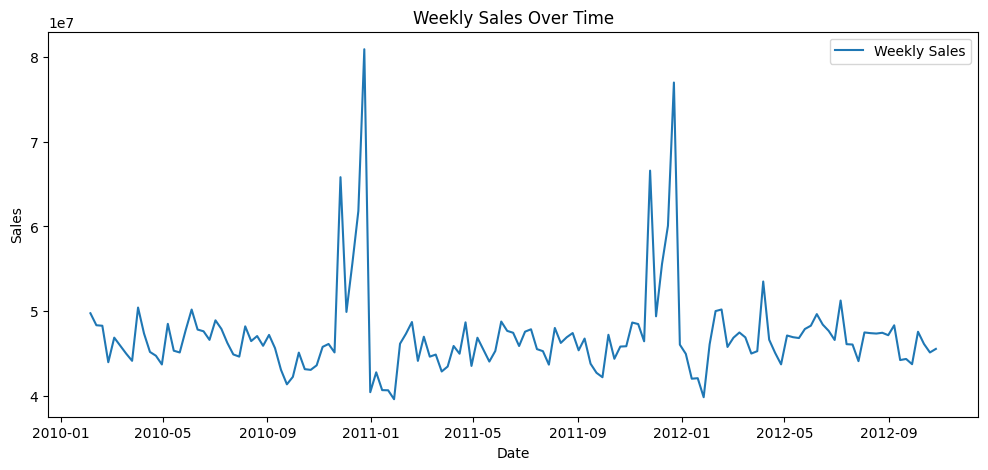

In [3]:
plt.figure(figsize=(12,5))
plt.plot(sales, label="Weekly Sales")
plt.title("Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [4]:
train_size = int(len(sales) * 0.8)
train, test = sales[:train_size], sales[train_size:]


In [5]:

model = ARIMA(train, order=(5,1,2))
arima_model = model.fit()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check ml

In [6]:
forecast_arima = arima_model.forecast(steps=len(test))

rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
mae_arima = mean_absolute_error(test, forecast_arima)

print("ARIMA RMSE:", rmse_arima)
print("ARIMA MAE:", mae_arima)


ARIMA RMSE: 2608467.540559114
ARIMA MAE: 2096276.1761885027


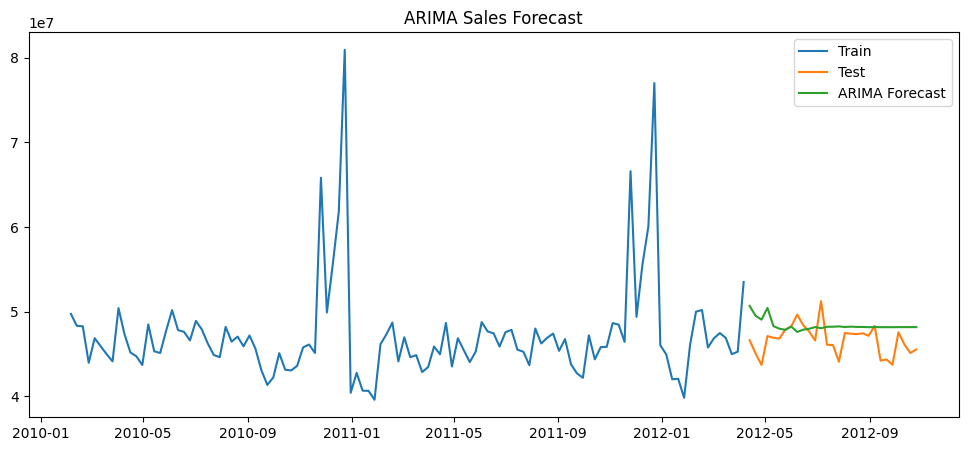

In [7]:
plt.figure(figsize=(12,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(test.index, forecast_arima, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Sales Forecast")
plt.show()


In [8]:
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(sales)


In [9]:
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_sales)


In [10]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - loss: 0.0521 - val_loss: 0.0085
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0257 - val_loss: 0.0032
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0212 - val_loss: 0.0068
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0322 - val_loss: 0.0033
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0241 - val_loss: 0.0019
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0254 - val_loss: 0.0027
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0213 - val_loss: 0.0027
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0244 - val_loss: 0.0022
Epoch 9/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0193 - val_loss: 0.0018
Epoch 10/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0232 - val_loss: 0.0026
Epoch 11/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0259 - val_loss: 0.0034
Epoch 12/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0304 - val_loss: 0.0028


In [13]:
lstm_pred = model.predict(X_test)

lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_actual = scaler.inverse_transform(y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step


In [14]:
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, lstm_pred))
mae_lstm = mean_absolute_error(y_test_actual, lstm_pred)

print("LSTM RMSE:", rmse_lstm)
print("LSTM MAE:", mae_lstm)


LSTM RMSE: 1887577.5012935605
LSTM MAE: 1399533.5525925944


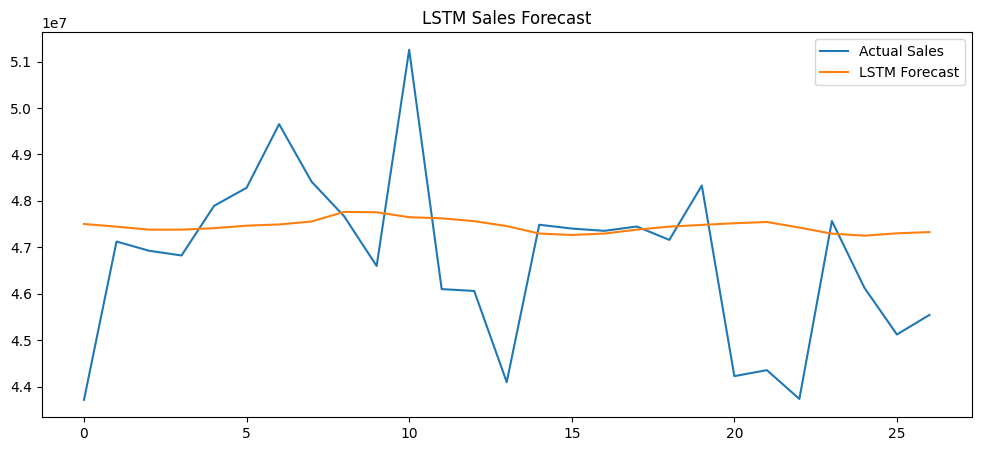

In [15]:
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label="Actual Sales")
plt.plot(lstm_pred, label="LSTM Forecast")
plt.legend()
plt.title("LSTM Sales Forecast")
plt.show()


In [16]:
print("Model Comparison")
print("-----------------")
print("ARIMA RMSE:", rmse_arima)
print("LSTM RMSE:", rmse_lstm)


Model Comparison
-----------------
ARIMA RMSE: 2608467.540559114
LSTM RMSE: 1887577.5012935605
